Tutorial 4: Bayesian Regularization
===================================

So, we can use an `Inversion` to reconstruct an image. Furthermore, this reconstruction provides the maximum log
likelihood solution. And, when we inspect the fit, we see residuals indicative of a good fit.

Everything sounds pretty good, doesn`t it? You`re probably thinking, why are there more tutorials? We can use
`Inversion`s now, don't ruin it! Well, there is a problem - which I hid from you in the last tutorial, which we'll
cover now.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

we're going to perform a lot of fits using an `Inversion` this tutorial. This would create a lot of code, so to keep 
things tidy, I've setup this function which handles it all for us.

(You may notice we include an option to `use_inversion_border, ignore this for now, as we'll be covering borders in 
the next tutorial)

In [3]:


def perform_fit_with_source_galaxy(imaging, source_galaxy):

    mask = al.Mask2D.circular_annular(
        shape_native=imaging.shape_native,
        pixel_scales=imaging.pixel_scales,
        sub_size=2,
        inner_radius=0.3,
        outer_radius=2.6,
    )

    masked_imaging = al.MaskedImaging(
        imaging=imaging, mask=mask, settings=al.SettingsMaskedImaging(sub_size=2)
    )

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllipticalIsothermal(
            centre=(0.0, 0.0),
            einstein_radius=1.6,
            elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
        ),
        shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


Okay, so lets look at our fit from the previous tutorial in more detail. we'll use a higher resolution 40 x 40 grid.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


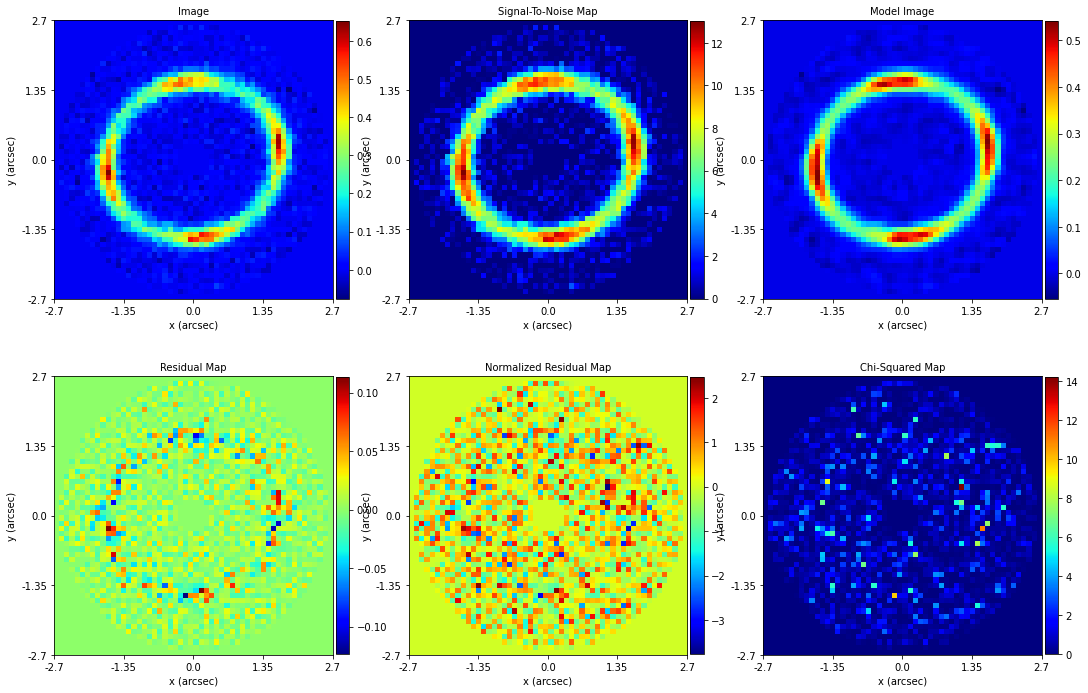

In [4]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_source_galaxy(imaging=imaging, source_galaxy=source_galaxy)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
fit_imaging_plotter.subplot_fit_imaging()

It looks pretty good! However, this is because I sneakily chose a regularization_coefficient that gives a good 
looking solution. If we reduce this regularization_coefficient to zero, our source reconstruction goes weird.

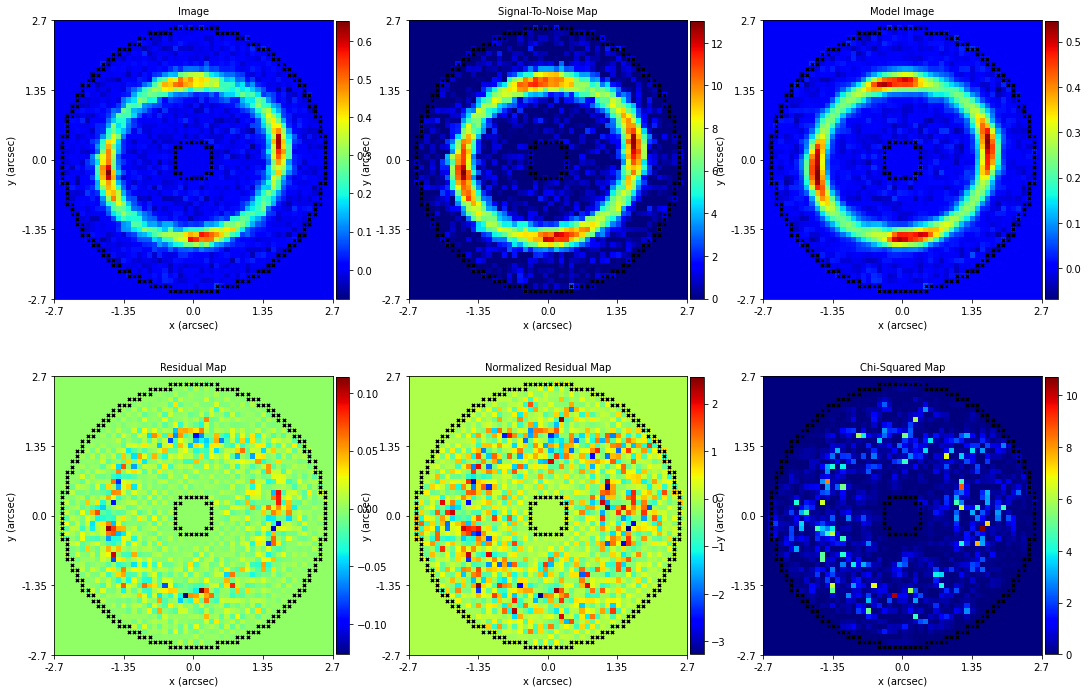

In [5]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=0.0),
)

no_regularization_fit = perform_fit_with_source_galaxy(
    imaging=imaging, source_galaxy=source_galaxy
)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=no_regularization_fit, include_2d=include_2d
)
fit_imaging_plotter.subplot_fit_imaging()

So, what`s happening here? Why does reducing the `Regularization` do this to our source reconstruction?

When our `Inversion` reconstructs a source, it doesn`t *just* compute the set of fluxes that best-fit the image. It 
also `regularizes` this solution, going to every pixel on our rectangular `Grid2D` and comparing its reconstructed flux 
with its 4 neighboring pixels. If the difference in flux is large the solution is penalized, reducing its log 
likelihood. You can think of this as us applying a prior that our source galaxy solution is `smooth`.

This adds a `penalty term` to the log likelihood of an `Inversion` which is the summed difference between the 
reconstructed fluxes of every source-pixel pair multiplied by the regularization_coefficient. By setting the 
regularization coefficient to zero, we set this penalty term to zero, meaning that `Regularization`.s omitted.

Why do we need to regularize our solution? Well, we just saw why - if we don't apply this smoothing, we `over-fit` 
the image. More specifically, we over-fit the noise in the image, which is what the large flux values located at
the exteriors of the source reconstruction are doing. Think about it, if your sole aim is to maximize the log 
likelihood, the best way to do this is to fit *everything* accurately, including the noise.

If we change the `normalization` variables of the `Plotter` such that the color-map is restricted to a narrower range of 
values, we can see that even without `Regularization`.e are still reconstructing the actual source galaxy.

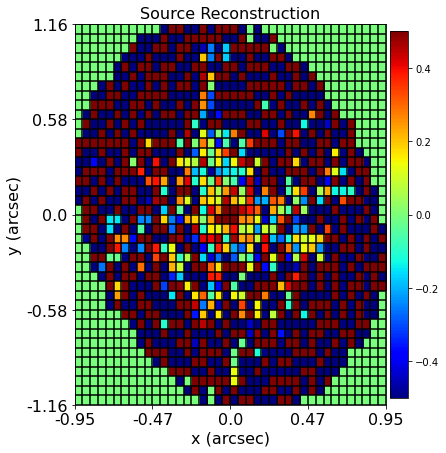

In [6]:
mat_plot_2d = aplt.MatPlot2D(cmap=aplt.Cmap(vmax=0.5, vmin=-0.5))

inversion_plotter = aplt.InversionPlotter(
    inversion=no_regularization_fit.inversion, mat_plot_2d=mat_plot_2d
)
inversion_plotter.figures(reconstruction=True)

Over-fitting is why `Regularization`.s necessary. Solutions like this completely ruin our attempts to model a strong 
lens. By smoothing our source reconstruction we ensure it doesn`t fit the noise in the image. If we set a really high 
regularization coefficient we completely remove over-fitting at the expense of also fitting the image less accurately.

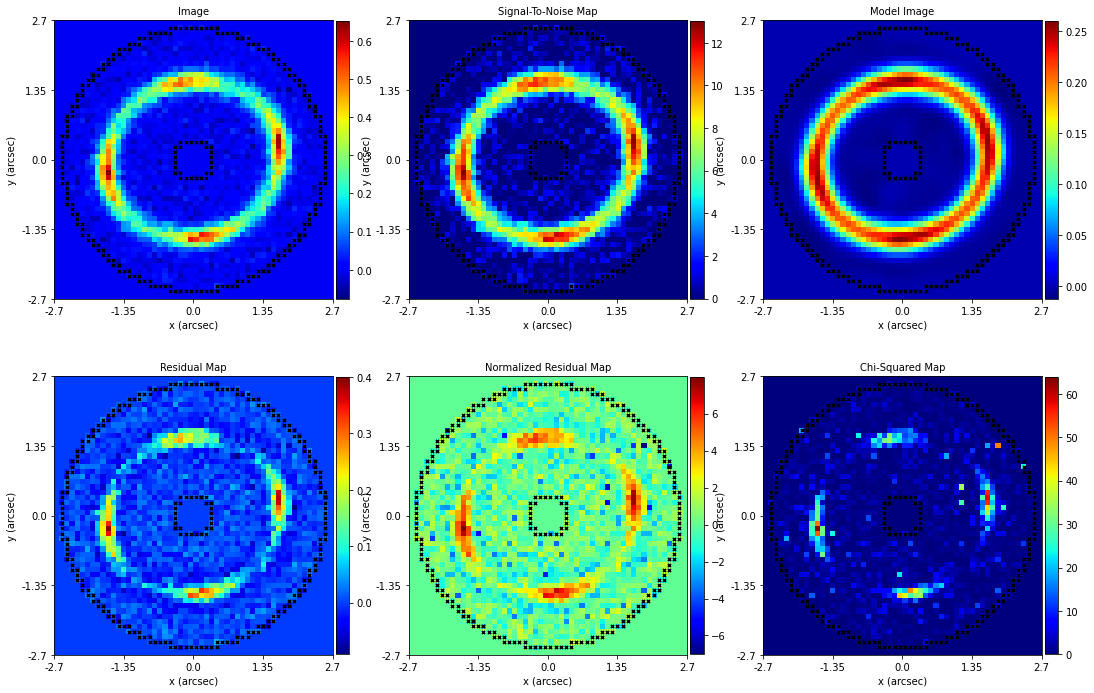

In [7]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=100.0),
)

high_regularization_fit = perform_fit_with_source_galaxy(
    imaging=imaging, source_galaxy=source_galaxy
)

fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=high_regularization_fit, include_2d=include_2d
)
fit_imaging_plotter.subplot_fit_imaging()

So, we now understand `Regularization`.nd its purpose. But there is one nagging question that remains, how do I choose 
the regularization_coefficient? We can`t use our log_likelihood, as decreasing the regularization_coefficient will 
always increase the log likelihood, because it allows the source reconstruction to fit the data better.

In [8]:
print("Likelihood Without Regularization:")
print(no_regularization_fit.log_likelihood_with_regularization)
print("Likelihood With Normal Regularization:")
print(fit.log_likelihood_with_regularization)
print("Likelihood With High Regularization:")
print(high_regularization_fit.log_likelihood_with_regularization)

Likelihood Without Regularization:
5616.249650512274
Likelihood With Normal Regularization:
5309.550894875563
Likelihood With High Regularization:
1790.4944869277642


If we used the log likelihood we will always choose a coefficient of 0! We need a different goodness-of-fit measure. 
For this, we invoke the `Bayesian Evidence`, which quantifies the goodness of the fit as follows:

 - First, it requires that the residuals of the fit are consistent with Gaussian noise (which is the noise expected 
 in the `Imaging`.. If this Gaussian pattern is not visible in the residuals, the noise must have been over-fitted. 
 Thus, the Bayesian log evidence decreases. Obviously, if the image is poorly fitted, the residuals don't appear 
 Gaussian either, but the poor fit will lead to a decrease in Bayesian log evidence decreases all the same!

 - This leaves us with a large number of solutions which all fit the data equally well (e.g., to the noise level). 
 To determine the best-fit from these solutions the Bayesian log evidence quantifies the complexity of each 
 solution`s source reconstruction. If the `Inversion` requires lots of pixels and a low level of `Regularization`
 to achieve a good fit, the Bayesian log evidence decreases. It penalizes solutions which are complex, which, in 
 a Bayesian sense, are less probable (you may want to look up `Occam`s Razor`).

If a really complex source reconstruction is paramount to fitting the image accurately than that is probably the 
correct solution. However, the Bayesian log evidence ensures we only invoke this more complex solution when the data 
necessitates it.

Lets take a look at the Bayesian log evidence:

In [9]:
print("Bayesian Evidence Without Regularization:")
print(no_regularization_fit.log_evidence)
print("Bayesian Evidence With Normal Regularization:")
print(fit.log_evidence)
print("Bayesian Evidence With High Regularization:")
print(high_regularization_fit.log_evidence)

Bayesian Evidence Without Regularization:
-6404.9445150465635
Bayesian Evidence With Normal Regularization:
3951.7767869710633
Bayesian Evidence With High Regularization:
1746.4031366555155


Great! As expected, the solution that we could see `by-eye` was the best solution corresponds to the highest log 
evidence solution.

Before we end, lets consider which aspects of an `Inversion` are linear and which are non-linear.

The linear part of the linear `Inversion` solves for the `best-fit` solution. For a given regularizaton coefficient, 
this includes the `Regularization` pattern. That is, we linearly reconstruct the combination of source-pixel fluxes 
that best-fit the image *including* the penalty term due to comparing neighboring source-pixel fluxes.

However, determining the regularization_coefficient that maximizes the Bayesian log evidence remains a non-linear 
problem and this becomes part of our non-linear search. The Bayesian log evidence also depends on the source resolution 
which means the pixel-grid resolution may also be part of our non-linear search. Nevertheless, this is only 3 
parameters - there were 30+ when using `LightProfile`'s to represent the source!

Here are a few questions for you to think about.

 1) We maximize the log evidence by using simpler source reconstructions. Therefore, decreasing the pixel-grid 
 size should provide a higher log_evidence, provided it still has enough resolution to fit the image well (and 
 provided that the `Regularization` coefficient is still an appropriate value). Can you increase the log evidence 
 from the value above by changing these parameters - I've set you up with a code to do so below.

Previous Bayesian Evidence:
3988.0716851250163
New Bayesian Evidence:
3951.7767869710633


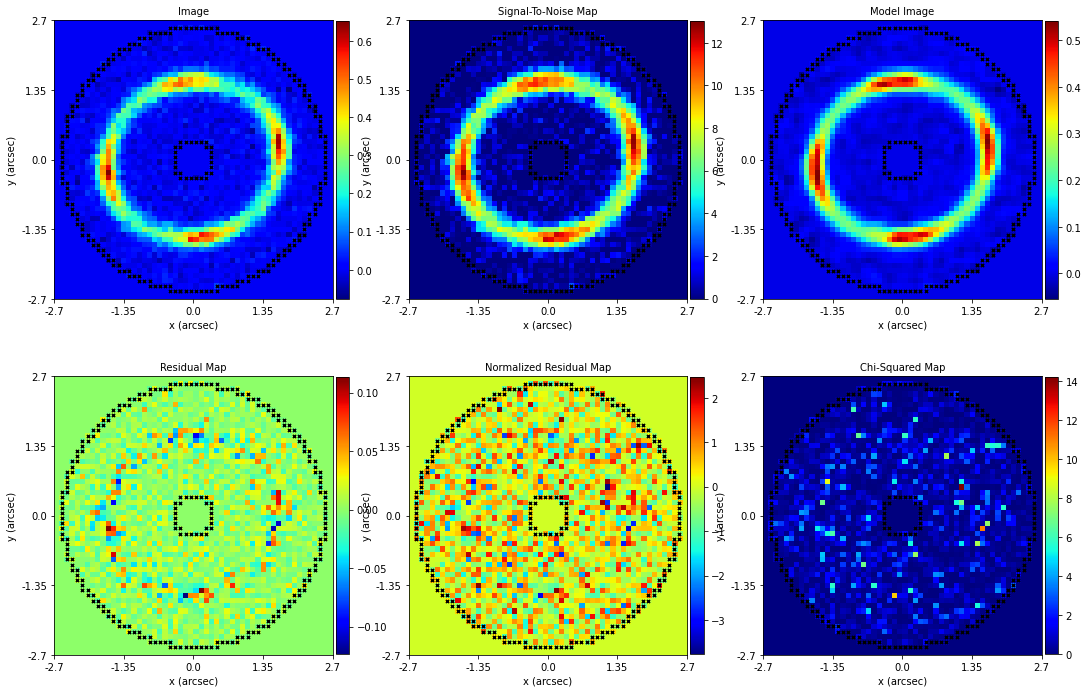

In [10]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_source_galaxy(imaging=imaging, source_galaxy=source_galaxy)

print("Previous Bayesian Evidence:")
print(3988.0716851250163)
print("New Bayesian Evidence:")
print(fit.log_evidence)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

2) Can you think of any other ways we might increase the log evidence even further? If not - don't worry. but 
you'll learn that **PyAutoLens** actually adapts its source reconstructions to the properties of the image that it is 
fitting, so as to objectively maximize the log evidence!